In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Heston SV Model with COS Method
def calc_D1(u, kappa, rho, gamma):
    return np.sqrt((kappa - 1j * rho * gamma * u)**2 + (u**2 + 1j * u) * gamma**2)


def calc_g(u, D1, kappa, rho, gamma):
    numerator = kappa - 1j * rho * gamma * u - D1
    denominator = kappa - 1j * rho * gamma * u + D1
    return numerator / denominator


def ChF_Heston(u, T, v0, vbar, gamma, kappa, rho, r):
    D1 = calc_D1(u, kappa, rho, gamma)
    g = calc_g(u, D1, kappa, rho, gamma)
    
    first_term = 1j*u*r*T + v0 / gamma**2 * ((1 - np.exp(-D1*T)) / (1 - g*np.exp(-D1*T))) *(kappa - 1j*rho*gamma*u - D1)
    second_term = kappa*vbar / gamma**2 * (T*(kappa - 1j*rho*gamma*u - D1) - 2*np.log((1 - g*np.exp(-D1*T)) / (1 - g)))
    
    return np.exp(first_term) * np.exp(second_term)


def xi_func(a, b, c, d, k):
    first_product = 1 / (1 + (k * np.pi / (b - a))**2)
    first_cos = np.cos(k * np.pi * (d - a) / (b - a)) * np.exp(d)
    second_cos = - np.cos(k * np.pi * (c - a) / (b - a)) * np.exp(c)
    first_sin = k * np.pi / (b - a) * np.sin(k * np.pi * (d - a) / (b - a)) * np.exp(d)
    second_sin = - k * np.pi / (b - a) * np.sin(k * np.pi * (c - a) / (b - a)) * np.exp(c)
    
    return first_product * (first_cos + second_cos + first_sin +second_sin)


def psi_func(a, b, c, d, k):
    if k == 0:
        return d - c
    else:
        first_sin = np.sin(k * np.pi * (d - a) / (b - a))
        second_sin = -np.sin(k * np.pi * (c - a) / (b - a))
        first_prod = (b - a) / (k * np.pi)
        return first_prod * (first_sin + second_sin)
    return 0


def U_func(a, b, k, opt_type='call'):
    if opt_type.upper() == 'CALL':
        c = 0
        d = b
        xi = xi_func(a, b, c, d, k)
        psi = psi_func(a, b, c, d, k)
        return 2 / (b - a) * (xi - psi)
    
    elif opt_type.upper == 'PUT':
        c = a
        d = 0
        xi = xi_func(a, b, c, d, k)
        psi = psi_func(a, b, c, d, k)
        return 2 / (b - a) * (-xi + psi)
    
    return 0

    
def HestonOptionValue(t0, S0, strikes, kappa, rho, gamma, v0, vbar, r, T, opt_type='call', L=3, N=160):
    X = np.log(S0 / strikes)
    a = -L * np.sqrt(T)
    b = -a
    
    result = 0
    
    for k in range(N):
        if k != 0:
            factor = 1
        else:
            factor = 0.5
            
        u = k * np.pi / (b - a)
        chf = ChF_Heston(u, T, v0, vbar, gamma, kappa, rho, r)
        Uk = U_func(a, b, k, opt_type)

        result += factor * np.real(ChF_Heston(u, T, v0, vbar, gamma, kappa, rho, r) * Uk * np.exp(1j * k * np.pi * (X - a) / (b - a)))
    
    return strikes * np.exp(-r * T) * result


# BlackScholes model for calculating implied volatility with Newton Raphson
class BlackScholesPricer:
    def __init__(self, S0, r, sigma, T, K):
        self.S0, self.r, self.sigma, self.T, self.K = S0, r, sigma, T, K
        self.d1 = self.calc_d1()
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
        self.call_price = self.calc_call_price()
        self.put_price = self.calc_put_price()
        self.call_delta = self.calc_call_delta()
        self.put_delta = self.calc_put_delta()
        
    def calc_d1(self):
        num = np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * (self.T)
        denom = self.sigma * np.sqrt(self.T)
        return num / denom
    
    def calc_call_price(self):
        return self.S0 * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    
    def calc_put_price(self):
        return self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - self.S0 * norm.cdf(-self.d1)
    
    def calc_call_delta(self):
        return norm.cdf(self.d1)
    
    def calc_put_delta(self):
        return norm.cdf(self.d1) - 1
    

class ImpliedVolatility:
    def __init__(self, V_call, S0, r, T, K):
        self.V_call, self.S0, self.r, self.T, self.K = V_call, S0, r, T, K
        self.sigma = None
        self.price = None
        
    def g_func(self, sigma_imp):
        return self.V_call - BlackScholesPricer(self.S0, self.r, sigma_imp, self.T, self.K).call_price

    def calc_d2(self, sigma_imp):
        return (np.log(self.S0 / self.K) + (self.r - 0.5*sigma_imp**2) * self.T) / (sigma_imp * np.sqrt(self.T))

    def g_prime_func(self, sigma_imp):
        return -self.K * np.exp(-self.r * self.T) * norm.cdf(self.calc_d2(sigma_imp)) * np.sqrt(self.T)
    
    def run_newton_raphson(self, initial_guess, eps=1e-5):
        sigma = initial_guess
        niter = 0
        
        while True:
            sigma_current = sigma - self.g_func(sigma) / self.g_prime_func(sigma)
            niter += 1
            
            if abs(sigma_current - sigma) <= eps or niter==1000:
                self.sigma = sigma_current
                self.price = BlackScholesPricer(self.S0, self.r, self.sigma, self.T, self.K).call_price
                return self.price, self.sigma
            else:
                sigma = sigma_current

In [65]:
strikes = np.arange(80, 120.1, 0.1)
r = 0
q = 0
kappa = 1.5768
gamma = 0.5751
vbar = 0.0398
v0 = 0.0175
rho = -0.5711
T = 1

call_values = HestonOptionValue(0, S0, strikes, kappa, rho, gamma, v0, vbar, r, T)

implied_vols = []

for v, k in zip(call_values, strikes):
    implied_vols.append(ImpliedVolatility(v, S0, r, T, k).run_newton_raphson(initial_guess=np.sqrt(vbar))[1])

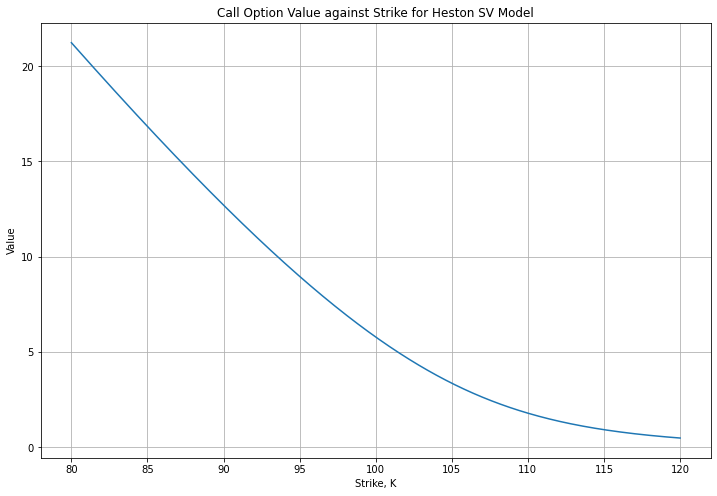

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(strikes, call_values)
plt.title('Call Option Value against Strike for Heston SV Model')
plt.xlabel('Strike, K')
plt.ylabel('Value')
plt.grid()

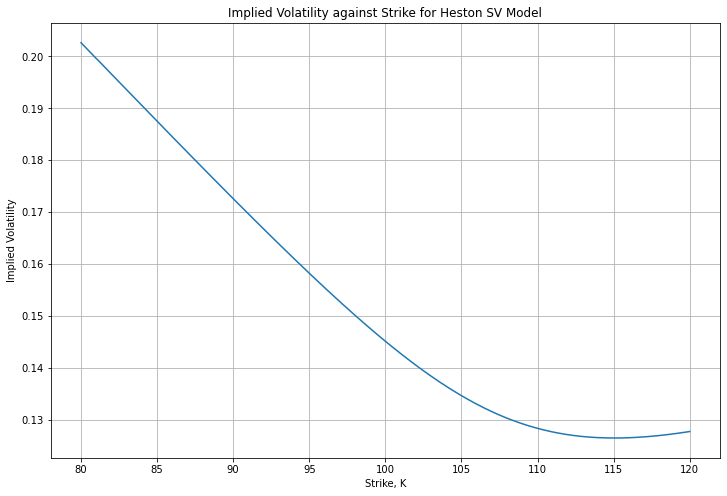

In [67]:
plt.figure(figsize=(12, 8))
plt.plot(strikes, implied_vols)
plt.title('Implied Volatility against Strike for Heston SV Model')
plt.xlabel('Strike, K')
plt.ylabel('Implied Volatility')
plt.grid()